In [2]:
import torch
import numpy as np
import h5py
import sys
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.table import Table
from matplotlib import mlab as mlab
from astroNN.shared.matplotlib import pylab_style
pylab_style(paper=True)

sys.path.append("..") # add higher direc to path
from xp_vae.model import ScatterVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using %s' % device)
torch.cuda.empty_cache()

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] =r"\usepackage{xcolor} "

import matplotlib as mpl

Using cpu


## Load data from XP/APOGEE cross-match

In [3]:
APOGEE_XP_XMATCH_PATH = '../data/xp_apogee_cat.h5'
f = h5py.File(APOGEE_XP_XMATCH_PATH,'r')['__astropy_table__']

# flux normalization
g_flux = f['phot_g_mean_flux'][:,np.newaxis]
xp = f['coeffs']/g_flux
xp_err = f['coeff_errs']/g_flux

# standard normalization
norm = np.load('../data/apogee_norm.npz')
xp_norm = (xp - norm['mu']) / norm['sig']
xp_err_norm = xp_err / norm['sig']

# stellar labels + redenning
teff = f['TEFF']
logg = f['LOGG']
m_h = f['M_H']
logebv = np.log10(f['SFD_EBV'])

# errors
teff_err = f['TEFF_ERR']
logg_err = f['LOGG_ERR']
m_h_err = f['M_H_ERR']

# other data for cuts
bp_rp = f['GAIAEDR3_PHOT_BP_MEAN_MAG'] - f['GAIAEDR3_PHOT_RP_MEAN_MAG']
mean_mag = f['GAIAEDR3_PHOT_G_MEAN_MAG']
starflag = f['STARFLAG']
aspcapflag = f['ASPCAPFLAG']

## Get test indices

In [9]:
from sklearn.model_selection import train_test_split
validation_split = 0.1 # default value

# split up xp data to match training (see xp_vae.model.fit), by index
idx = np.arange(len(xp))
idx_train,idx_val = train_test_split(idx,test_size=validation_split,random_state=12345)

## Load *s*VAE

In [10]:
from xp_vae.model import ScatterVAE

model = ScatterVAE().to(device)
weights = torch.load('../models/APOGEE_MODEL/weight.pt',map_location=device)
model.load_state_dict(state_dict=weights['model_state_dict'])
model.eval()

ScatterVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=110, out_features=90, bias=True)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=70, bias=True)
      (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=70, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): Batc

In [11]:
in1 = torch.from_numpy(xp_norm).cpu().to(device)
in2 = torch.from_numpy(xp_err_norm).to(device)

_,_,mu,log_var,est,s = model.forward(in1,in2)

est = est.detach().cpu().numpy()*norm['sig']+norm['mu']
s = s.detach().cpu().numpy()*norm['sig']
latent = model.reparam(mu.cpu().to(device),log_var.cpu().to(device)).cpu().detach().numpy()

## Load large astronomy model - [Leung & Bovy (2023)](https://arxiv.org/abs/2308.10944)

You will need to download their [model](https://github.com/henrysky/astroNN_stars_foundation) to run this notebook

In [15]:
import sys
sys.path.append('../../astroNN_stars_foundation')
from stellarperceptron.model import StellarPerceptron

lam_model = StellarPerceptron.load("../../astroNN_stars_foundation/model_torch", mixed_precision=False, device=device)
# can only perceive 32 first BP and 32 first RP coeffs because of length 64 context window
xp_list = [f"bp{i}" for i in range(32)] + [f"rp{i}" for i in range(32)] 

### Stellar label dependent implementation of LB23

You will need to run the code in this cell to generate `lam_est_labels` (approx 50 min on cpu)

In [19]:
# Perceive XP, request labels, perceive labels, request XP

'''
lam_model.perceive(xp[:,np.r_[0:32,55:87]][idx_val],xp_list) # perceive the normalized XP spectra (but only 64 coeffs)
print('Perceived XP')
label_names = ['teff','logg','m_h','jh','jk']
res_int = lam_model.request(label_names) # request stellar labels + J-H & J-k
print('Requested labels')
lam_model.clear_perception() # forget normalized XP spectra
print('Cleared perception')
lb23_labels = np.column_stack([res_int[col] for col in label_names])
lam_model.perceive(lb23_labels,['teff','logg','m_h','jh','jk']) # perceive stellar labels + J-H & J-k
print('Perceived labels')
res = lam_model.request(xp_list) # request the normalized XP spectra (but only 64 coeffs)
print('Requested XP')

lam_bp_est = np.array([res[f"bp{i}"].to_numpy() for i in range(32)])
lam_rp_est = np.array([res[f"rp{i}"].to_numpy() for i in range(32)])
lam_est_labels = np.concatenate((lam_bp_est,lam_rp_est)).T

np.save('../data/lb23_xp_est_labels.npy',lam_est_labels)
'''

lam_est_labels = np.load('../data/lb23_xp_est_labels.npy')

### Stellar label independent implementation of LB23

You will need to run the code in this cell to generate `lam_est_no_labels` (appro 20 min on cpu)

In [22]:
# Perceive XP, request XP
'''
lam_model.perceive(xp[:,np.r_[0:32,55:87]][idx_val],xp_list) # perceive the normalized XP spectra (but only 64 coeffs)
print('Perceived XP')
res = lam_model.request(xp_list) # request the normalized XP spectra (but only 64 coeffs)
print('Requested XP')

lam_bp_est = np.array([res[f"bp{i}"].to_numpy() for i in range(32)])
lam_rp_est = np.array([res[f"rp{i}"].to_numpy() for i in range(32)])
lam_est_no_labels = np.concatenate((lam_bp_est,lam_rp_est)).T

np.save('../data/lb23_xp_est_no_labels.npy', lam_est_no_labels)
'''
lam_est_no_labels = np.load('../data/lb23_xp_est_no_labels.npy')

## Compute reconstructions errors to compare with LB23

In [24]:
# Note: only first 32 BP and RP coefficients

# For the sVAE...
model_err_star = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=1)/64)
model_err_coeff = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=0)/110)

# ...for the stellar label dependent implementation...
lam_err_star_labels = np.sqrt(np.sum( ( (lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=1)/64) 
lam_err_coeff_labels = np.sqrt(np.sum( ( (lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=0)/110)

lam_err_star_no_labels = np.sqrt(np.sum( ( (lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=1)/64) 
lam_err_coeff_no_labels = np.sqrt(np.sum( ( (lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=0)/110)

In [25]:
# now compute the mean coefficient error (again, for 64 coefficients)

# sVAE
model_err_coeff_mean = np.mean( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=0)
# LB23 - stellar label dependent
lam_err_coeff_mean_labels = np.mean( ((lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=0)
# LB23 - stellar label independent
lam_err_coeff_mean_no_labels = np.mean( ((lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=0)

## Compare reconstructions errors to LB23 as a function of coefficients

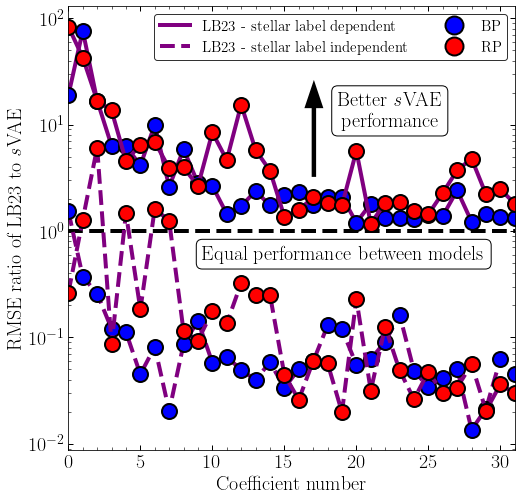

In [68]:
fig,ax = plt.subplots(figsize=(8,8),sharex=False,sharey=False)
lw=4
ms=15

# models have equivalent performance at ratio = 1
ax.axhline(1,ls='--',c='k',lw=lw)

coeff_nums = np.arange(32)
# full catalog - LB23 stellar label dependent
ax.plot(coeff_nums,lam_err_coeff_mean_labels[:32]/model_err_coeff_mean[:32],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,
        markerfacecolor='b')
ax.plot(lam_err_coeff_mean_labels[32:]/model_err_coeff_mean[32:],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,
        markerfacecolor='r')
# full catalog - LB23 stellar label independent
ax.plot(coeff_nums,lam_err_coeff_mean_no_labels[:32]/model_err_coeff_mean[:32],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,ls='--',
        markerfacecolor='b')
ax.plot(lam_err_coeff_mean_no_labels[32:]/model_err_coeff_mean[32:],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,ls='--',
        markerfacecolor='r')

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_ylabel(r'RMSE ratio of LB23 to \emph{s}VAE')
ax.set_xlabel(r'Coefficient number')
ax.set_xlim(0,31)
#ax.set_ylim(10**-0.3,10**2)

from matplotlib.lines import Line2D
leg_elements = [Line2D([0], [0], color='purple', lw=lw, label='LB23 - stellar label dependent'),
                Line2D([0], [0], color='purple', lw=lw, label='LB23 - stellar label independent',ls='--'),
                Line2D([0], [0], color='w', markerfacecolor='b',markeredgewidth=2,markeredgecolor='k', marker='o',label='BP'),
                Line2D([0], [0], color='w', markerfacecolor='r',markeredgewidth=2,markeredgecolor='k', marker='o',label='RP')]
leg = ax.legend(handles=leg_elements, loc='upper right',fontsize=15,ncol=2)
leg.get_frame().set_edgecolor('k')

# arrow explaining plot
ax.arrow(0.55,0.62,0,0.2,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.72,0.73,'Better \emph{s}VAE\nperformance',
        transform=ax.transAxes,fontsize=20,horizontalalignment='center',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

ax.text(0.3,0.43,'Equal performance between models',
        transform=ax.transAxes,fontsize=20,c='k',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

plt.savefig('../figures/compare_lam.png',dpi=400,bbox_inches='tight')
plt.show()

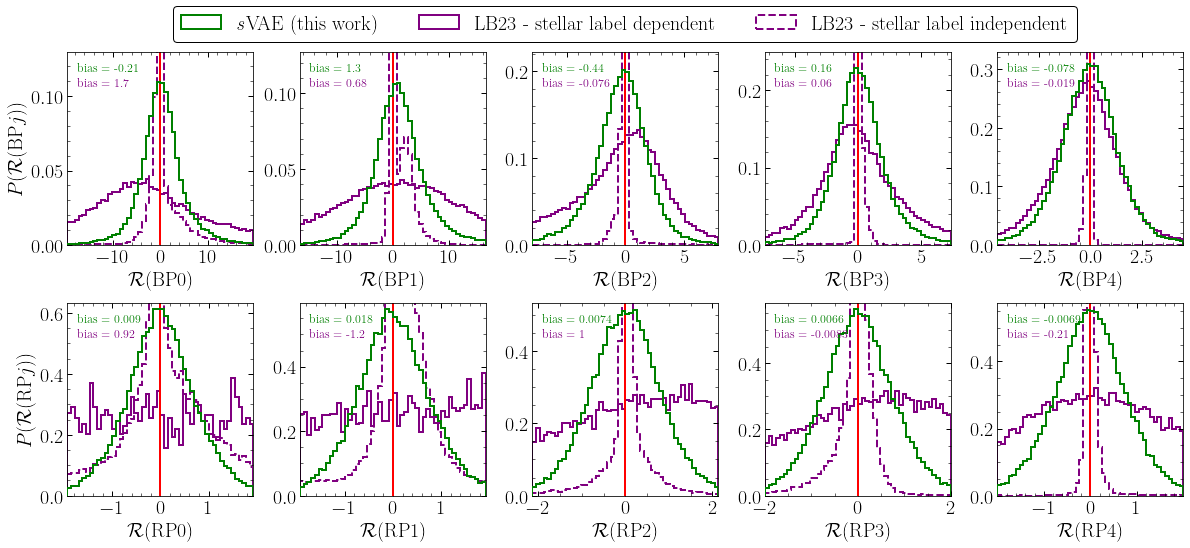

In [89]:
fig,ax=plt.subplots(2,5,figsize=(20,8),sharex=False,sharey=False)
plt.subplots_adjust(hspace=.3,wspace=.25)
coeffs = [0,1,2,3,4,32,33,34,35,36]
nbins = 51
lw = 2

color='green'
for i,coeff in enumerate(coeffs):

    if coeff < 32: 
        ax.flatten()[i].set_xlabel(r'$\mathcal{R}(\mathrm{BP}%s)$' % coeff)
    if coeff >= 32: 
        ax.flatten()[i].set_xlabel(r'$\mathcal{R}(\mathrm{RP}%s)$' % (coeff-32))

    model_err = (est[idx_val][:,coeff]-xp[idx_val][:,coeff])/xp_err[idx_val][:,coeff]
    sig_lim = (abs(np.percentile(model_err, 1.)) + np.percentile(model_err, 99.))/2
    bins = np.linspace(-sig_lim,sig_lim,nbins)
    n,_,_ = ax.flatten()[i].hist(model_err,
                        bins=bins,alpha=1,density=True,histtype=u'step',lw=lw,zorder=3,color=color,label=r' \emph{s}VAE (this work)')
    ax.flatten()[i]
    
    # stellar label dependent
    foundation_model_err = (lam_est_labels[:,coeff]-xp[idx_val][:,np.r_[0:32,55:87]][:,coeff])/xp_err[idx_val][:,np.r_[0:32,55:87]][:,coeff]
    ax.flatten()[i].hist(foundation_model_err,
                        bins=bins,alpha=1,density=True,color='purple',histtype=u'step',lw=lw,zorder=1,label=r'LB23 - stellar label dependent')
    
    # stellarlabel independent
    foundation_model_err = (lam_est_no_labels[:,coeff]-xp[idx_val][:,np.r_[0:32,55:87]][:,coeff])/xp_err[idx_val][:,np.r_[0:32,55:87]][:,coeff]
    ax.flatten()[i].hist(foundation_model_err,
                        bins=bins,alpha=1,density=True,color='purple',histtype=u'step',ls='--',lw=lw,zorder=1,label=r'LB23 - stellar label independent')

    ax.flatten()[i].set_xlim(-sig_lim,sig_lim)
    ax.flatten()[i].set_ylim(0.,np.max(n)+0.02)
    ax.flatten()[i].axvline(0,c='red',lw=lw)

    ax.flatten()[i].text(.05,.9,
                        r'bias = %.2g' % np.mean(model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c=color)
    ax.flatten()[i].text(.05,.825,
                        r'bias = %.2g' % np.mean(foundation_model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c='purple')

ax.flatten()[0].set_ylabel(r'$P(\mathcal{R}(\mathrm{BP}j))$')
ax.flatten()[5].set_ylabel(r'$P(\mathcal{R}(\mathrm{RP}j))$')

leg2 = ax[1,4].legend(fontsize=20,framealpha=1,loc='lower right',bbox_to_anchor=(.48,2.3),ncol=3)
leg2.get_frame().set_edgecolor('k')

plt.savefig('../figures/lam_coeff_errs.png',dpi=400,bbox_inches='tight')
plt.show()

## Compare with deep stellar label model - [Zhang, Green, Rix (2023)](https://arxiv.org/abs/2303.03420)

You will need to download their [model](https://zenodo.org/records/7811871) to run this notebook.

In [91]:
import tensorflow as tf

zhang_nn_model = tf.saved_model.load("../../stellar_flux_model")
zhang_sample_wavelengths = zhang_nn_model._sample_wavelengths.numpy()

# optimized stellar labels from ZGR23, cross-matched to APOGEE (see scripts.cross_match_zhang.py)
zhang_stellar_param_vecs = np.load('../data/zhang_stellar_params_xmatch.npy',allow_pickle=True)
zhang_stellar_param_vecs[zhang_stellar_param_vecs == 0] = np.nan

zhang_est = zhang_nn_model.predict_observed_flux(zhang_stellar_param_vecs[:,:3],
                                                 zhang_stellar_param_vecs[:,3],
                                                 100*zhang_stellar_param_vecs[:,4]).numpy()

2024-02-11 13:10:50.007413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Convert XP coefficients to wavelengths for ZGR23 comparison

In [93]:
# see scripts.convert_to_wavelength.py

from gaiaxpy.core.config import _load_xpmerge_from_xml, _load_xpsampling_from_xml
xp_sampling_grid, xp_merge = _load_xpmerge_from_xml()
xp_design_matrices = _load_xpsampling_from_xml()

wavelength_mask_xp = np.array([lam in zhang_sample_wavelengths for lam in xp_sampling_grid]) 
wavelength_mask_zhang = np.array([lam in xp_sampling_grid for lam in zhang_sample_wavelengths])

vae_wavelength_space = np.load('../data/vae_wavelength_space.npy')
xp_wavelength_space = np.load('../data/xp_wavelength_space.npy')
err_wavelength_space = np.load('../data/err_wavelength_space.npy')

## Compare reconstruction errors to ZGR23 as a function of wavelength

In [94]:
# compute rmse in wavelength space

model_err_star_wavelength = np.sqrt(np.nanmean( ( ( (vae_wavelength_space-xp_wavelength_space[idx_val])/err_wavelength_space )**2.), axis=0))
zhang_err_star_wavelength = np.sqrt(np.nanmean( ( ( (zhang_est[:,:-5]/1e22-xp_wavelength_space[idx_val])/err_wavelength_space )**2.), axis=0))


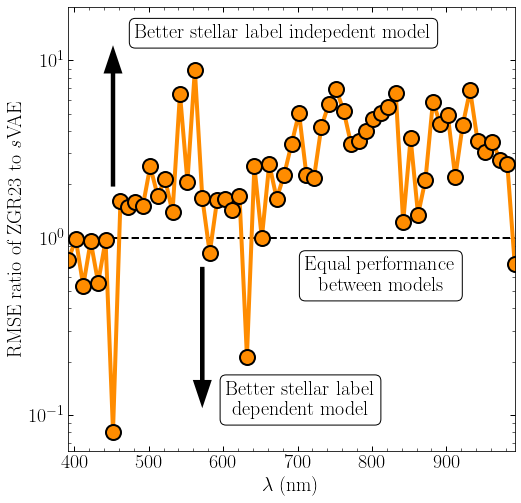

In [175]:
fig,ax = plt.subplots(figsize=(8,8),sharex=False,sharey=False)
lw=4

# equal model performance
ax.axhline(1,c='k',ls='--',lw=2)

# full catalog
ax.plot(zhang_sample_wavelengths[:-5],zhang_err_star_wavelength/model_err_star_wavelength,lw=lw,c='darkorange',label='Full catalog',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2)
#ax.plot(zhang_sample_wavelengths[:-5],zhang_err_star_wavelength_good/model_err_star_wavelength_good,lw=lw,c='g',label='Good labels',ls=':')
#ax.plot(zhang_sample_wavelengths[:-5],zhang_err_star_wavelength_pristine/model_err_star_wavelength_pristine,lw=lw,c='g',label='Pristine labels',ls='--')

ax.set_yscale('log')
ax.set_ylim(10**-1.2,10**1.3)
ax.set_xlim(zhang_sample_wavelengths[:-5][0],zhang_sample_wavelengths[:-5][-1])

ax.set_xlabel(r'$\lambda$ (nm)')
ax.set_ylabel(r'RMSE ratio of ZGR23 to \emph{s}VAE')

# arrows explaining plot
ax.arrow(0.1,0.6,0,0.3,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.15,0.93,'Better stellar label indepedent model',
        transform=ax.transAxes,fontsize=20,bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

ax.arrow(0.3,0.41,0,-0.3,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.52,0.08,'Better stellar label \n dependent model',
        transform=ax.transAxes,fontsize=20,horizontalalignment='center',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

ax.text(0.7,0.36,'Equal performance \n between models',
        transform=ax.transAxes,fontsize=20,c='k',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'),horizontalalignment='center')

plt.savefig('../figures/compare_zgr.png',dpi=400,bbox_inches='tight')
plt.show()

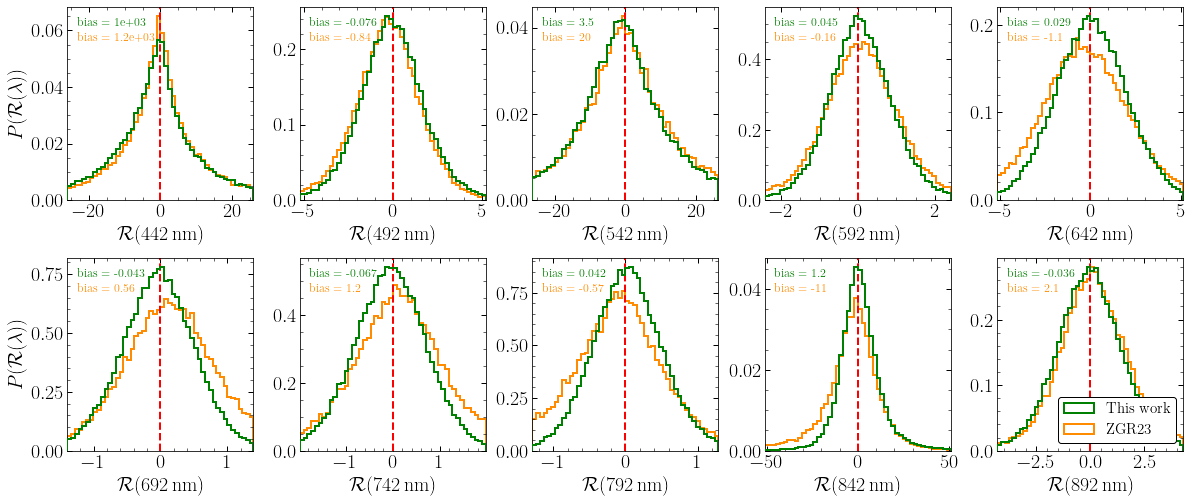

In [177]:
fig,ax=plt.subplots(2,5,figsize=(20,8),sharex=False,sharey=False)
plt.subplots_adjust(hspace=.3,wspace=.25)
coeffs = [5,10,15,20,25,30,35,40,45,50] # not actually coeffs, they are now wavelength idxs
color = 'green'
nbins = 51
lw = 2
for i,coeff in enumerate(coeffs):

    ax.flatten()[i].set_xlabel(r'$\mathcal{R}(%s\,\mathrm{nm})$' % int(zhang_sample_wavelengths[coeff]))

    model_err = (vae_wavelength_space[:,coeff]-xp_wavelength_space[idx_val][:,coeff])/err_wavelength_space[:,coeff]
    sig_lim = (abs(np.percentile(model_err, 1.)) + np.percentile(model_err, 99.))/2
    if i==0 or i==2: # these wavelengths have huge tails for both models, trim sides
        sig_lim = (abs(np.percentile(model_err, 10.)) + np.percentile(model_err, 90.))/2
    bins = np.linspace(-sig_lim,sig_lim,nbins)
    ax.flatten()[i].hist(model_err,
                        bins=bins,alpha=1,density=True,histtype=u'step',lw=lw,zorder=3,color=color,label=r'This work')
    ax.flatten()[i]
    
    zgr_err = (zhang_est[:,coeff]/1e22-xp_wavelength_space[idx_val][:,coeff])/err_wavelength_space[:,coeff]
    ax.flatten()[i].hist(zgr_err,
                        bins=bins,alpha=1,density=True,color='darkorange',histtype=u'step',lw=lw,zorder=1,label=r'ZGR23')

    ax.flatten()[i].set_xlim(-sig_lim,sig_lim)
    ax.flatten()[i].axvline(0,c='r',ls='--',lw=lw)

    if i==0 or i==5:
        ax.flatten()[i].set_ylabel(r'$P(\mathcal{R}(\lambda))$')
        ax.flatten()[i].set_ylabel(r'$P(\mathcal{R}(\lambda))$')

    ax.flatten()[i].text(.05,.9,
                        r'bias = %.2g' % np.mean(model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c=color)
    ax.flatten()[i].text(.05,.825,
                        r'bias = %.2g' % np.nanmean(zgr_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c='darkorange')

#leg1 = ax[0,4].legend(fontsize=15,framealpha=1,loc='lower right')
leg2 = ax[1,4].legend(fontsize=15,framealpha=1,loc='lower right')
#leg1.get_frame().set_edgecolor('k')
leg2.get_frame().set_edgecolor('k')

plt.savefig('../figures/zgr_rel_errs.png',dpi=400,bbox_inches='tight')
plt.show()

## Error distributions as a function of stellar labels

In [179]:
# Need to first compute total error for each test star

model_err = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=1)/64)
lam_err_labels = np.sqrt(np.sum( ((lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=1)/110)
lam_err_no_labels = np.sqrt(np.sum( ((lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=1)/110)

model_err_wavelength = np.sqrt(np.nanmean( ((vae_wavelength_space-xp_wavelength_space[idx_val])/err_wavelength_space)**2., axis=1))
zhang_err = np.sqrt(np.nanmean( ((zhang_est[:,:-5]/1e22-xp_wavelength_space[idx_val])/err_wavelength_space)**2., axis=1))

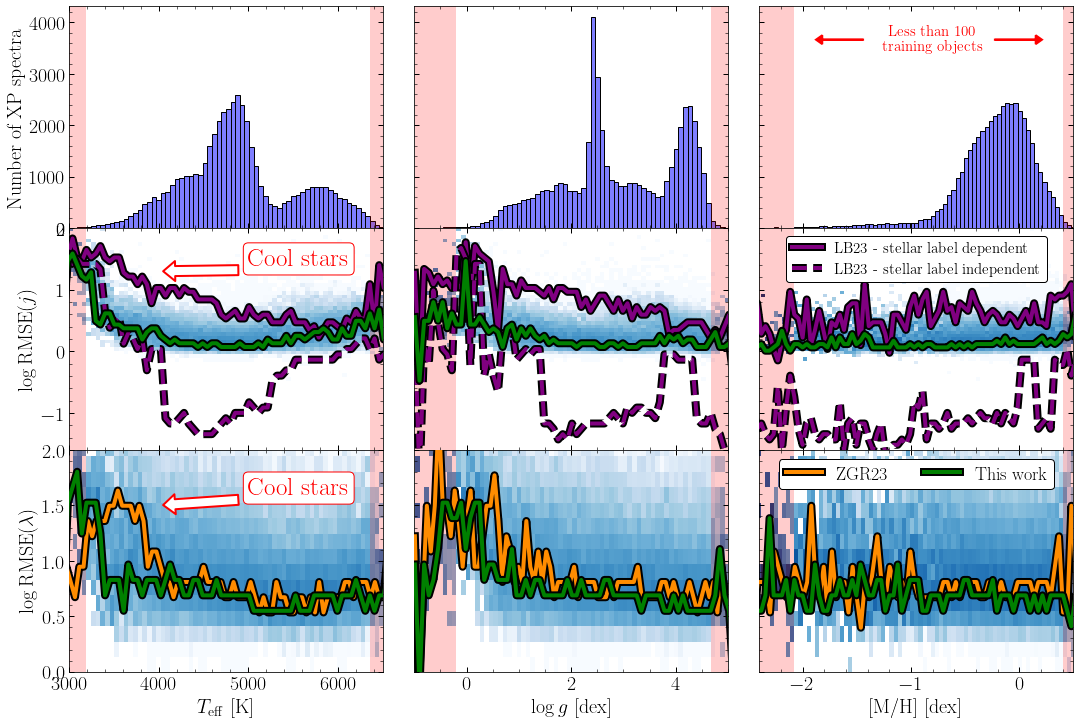

In [181]:
fig, ax = plt.subplots(3,3,figsize=(18,12),sharex='col',sharey='row')
plt.subplots_adjust(wspace=0.1,hspace=0.)

bins_x = 80
bins_y = 50
vae_color = 'Blues'
mode_color='green'
lam_color = 'purple'
zhang_color = 'darkorange'
lw = 4

import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=8, foreground='k')

# LB23 errors as function of stellar labels (coeffs) - for stellar label dependent model
for i,stellar_label in enumerate([teff,logg,m_h]):
    hist,xedges,yedges = np.histogram2d(stellar_label[idx_val][np.isfinite(stellar_label[idx_val])],np.log10(lam_err_labels)[np.isfinite(stellar_label[idx_val])],bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=lam_color,lw=lw,zorder=3,label='LB23 - stellar label dependent',path_effects=[outline])

# LB23 errors as function of stellar labels (coeffs) - for stellar label independent model
for i,stellar_label in enumerate([teff,logg,m_h]):
    hist,xedges,yedges = np.histogram2d(stellar_label[idx_val][np.isfinite(stellar_label[idx_val])],np.log10(lam_err_no_labels)[np.isfinite(stellar_label[idx_val])],bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=lam_color,ls='--',lw=lw,zorder=3,label='LB23 - stellar label independent',path_effects=[outline])

# sVAE errors as function of stellar labels (coeffs)
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(model_err)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].pcolormesh(X,Y,hist,cmap=vae_color,norm=mpl.colors.LogNorm(vmin=np.log10(2)))
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=mode_color,lw=lw,zorder=3,path_effects=[outline])

# ZGR23 errors as function of stellar labels (wavelength)
for i,stellar_label in enumerate([teff,logg,m_h]):
    # need to include nan mask here because of missing stars during cross-match
    hist,xedges,yedges = np.histogram2d(stellar_label[idx_val][np.isfinite(zhang_err)*np.isfinite(stellar_label[idx_val])],
                                        np.log10(zhang_err)[np.isfinite(zhang_err)*np.isfinite(stellar_label[idx_val])],bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[2,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=zhang_color,lw=lw,zorder=3,label='ZGR23',path_effects=[outline])

# sVAE errors as function of stellar labels (wavelengths)
for i,stellar_label in enumerate([teff,logg,m_h]):
    hist,xedges,yedges = np.histogram2d(stellar_label[idx_val][np.isfinite(stellar_label[idx_val])],
                                        np.log10(model_err_wavelength)[np.isfinite(stellar_label[idx_val])],bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[2,i].pcolormesh(X,Y,hist,cmap=vae_color,norm=mpl.colors.LogNorm(vmin=np.log10(2)))
    ax[2,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=mode_color,lw=lw,zorder=3,label='This work',path_effects=[outline])

# plot stellar label distributions
for i,stellar_label in enumerate([teff,logg,m_h]):
    hist,xedges,yedges = np.histogram2d(stellar_label[idx_val][np.isfinite(stellar_label[idx_val])],np.log10(model_err)[np.isfinite(stellar_label[idx_val])]
                                        ,bins=(bins_x,bins_y)) # dummy hist to get xedges
    ax[0,i].hist(stellar_label[idx_val],lw=1,color='blue',density=False,bins=xedges,alpha=.5,edgecolor='None')
    hist = ax[0,i].hist(stellar_label[idx_val],lw=1,density=False,bins=xedges,edgecolor='k', facecolor="None")

    for j in range(3):
        thresh = hist[1][np.argmin(np.abs(np.cumsum(hist[0])-100.))]
        ax[j,i].axvspan(min(stellar_label[idx_val]),thresh,facecolor='red',lw=3,alpha=0.2,zorder=1)
        thresh = hist[1][np.argmin(np.abs(np.cumsum(hist[0])-(sum(hist[0])-100.)))]
        ax[j,i].axvspan(thresh,max(stellar_label[idx_val]),facecolor='red',lw=3,alpha=0.2,zorder=1)

ax[0,0].set_xlim(3000,6500)
ax[0,1].set_xlim(-1,5)
ax[0,2].set_xlim(-2.4,0.5)

ax[1,0].set_ylim(-1.6,2)
ax[2,0].set_ylim(0,2)

ax[2,0].set_xlabel(r'$T_{\rm eff}$ [K]')
ax[2,1].set_xlabel(r'$\log g$ [dex]')
ax[2,2].set_xlabel(r'[M/H] [dex]')

ax[0,0].set_ylabel('Number of XP spectra')
ax[1,0].set_ylabel(r'$\log\mathrm{RMSE}(j)$')
ax[2,0].set_ylabel(r'$\log\mathrm{RMSE}(\lambda)$')

leg1 = ax[1,2].legend(fontsize=15,framealpha=1,loc='upper center')
leg1.get_frame().set_edgecolor('k')
leg2 = ax[2,2].legend(fontsize=18,framealpha=1,ncol=2,loc='upper center')
leg2.get_frame().set_edgecolor('k')

ax[0,2].text(0.55,0.8,'Less than 100 \n training objects',horizontalalignment='center',transform=ax[0,2].transAxes,fontsize=15,color='red')
ax[0,2].arrow(0.33,0.85,-0.15,0,fc='r',ec='r',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)
ax[0,2].arrow(0.75,0.85,0.15,0,fc='r',ec='r',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)

bbox = dict(boxstyle='round', fc='white', edgecolor='red', pad=.2)
arrowprops = dict(facecolor='w', shrink=0.05, edgecolor='r',lw=2, width=10, headwidth=20)
ax[2,0].annotate('Cool stars', xy=(4000, 1.5), xytext=(5000, 1.6),
            arrowprops=arrowprops,bbox=bbox,
            zorder=20,transform=ax[2,0].transAxes,fontsize=25,color='red',
            )
ax[1,0].annotate('Cool stars', xy=(4000, 1.3), xytext=(5000, 1.4),
            arrowprops=arrowprops,bbox=bbox,
            zorder=20,transform=ax[2,0].transAxes,fontsize=25,color='red',
            )

plt.savefig('../figures/err_stellar_labels.png',dpi=400,bbox_inches='tight')
plt.show()